In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [5]:
X[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

In [6]:
X.shape

(1797, 64)

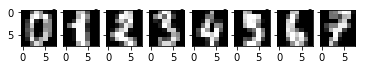

In [7]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [8]:
from sklearn.model_selection import learning_curve

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [10]:
K.clear_session()

In [11]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
initial_weights= model.get_weights()

In [13]:
y_cat = to_categorical(y, 10)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [16]:
train_sizes= (len(X_train)*np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [17]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


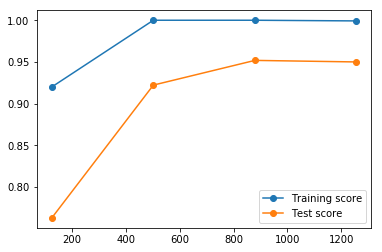

In [18]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

In [19]:
from keras.layers import BatchNormalization

In [20]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [21]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [22]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [23]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

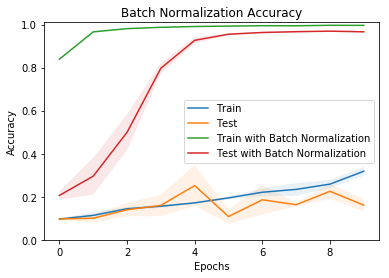

In [24]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


In [25]:
from keras.layers import Dropout

In [26]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [28]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 1 classes.


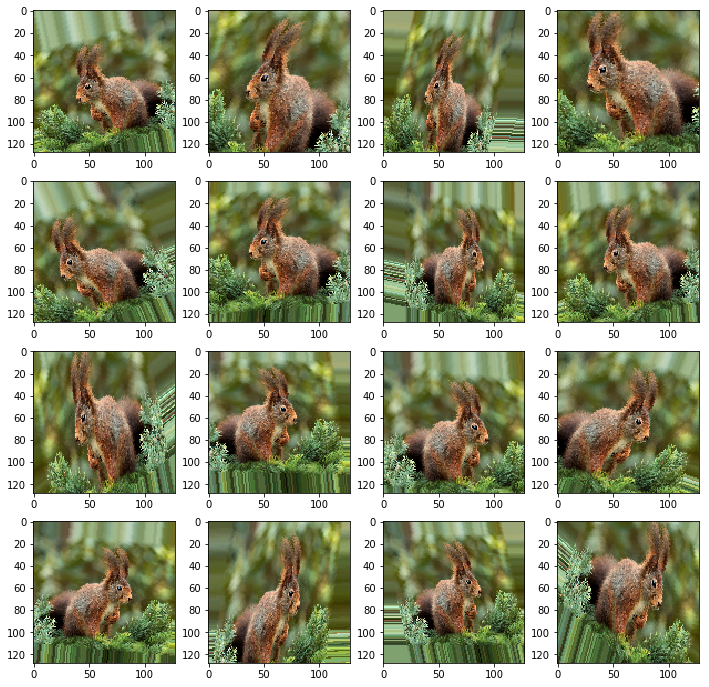

In [29]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

In [30]:
from keras.layers import Embedding

In [31]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [33]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [34]:
emb.shape

(3, 4, 2)

In [35]:
emb

array([[[ 0.03789291, -0.0338621 ],
        [-0.01155697,  0.00941794],
        [ 0.03453069, -0.00569571],
        [ 0.02671539, -0.0165273 ]],

       [[-0.0435771 ,  0.00600537],
        [-0.03696151, -0.03811275],
        [-0.02002103,  0.00555946],
        [ 0.00061364, -0.02954913]],

       [[-0.01586776, -0.04188732],
        [-0.00529528,  0.04007459],
        [-0.02684034,  0.03389548],
        [-0.00372588,  0.01664085]]], dtype=float32)

In [36]:
from keras.datasets import imdb

In [37]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [38]:
X_train.shape

(25000,)

In [39]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [40]:
idx = imdb.get_word_index()

In [41]:
idx

{'annabelle': 30365,
 'vagabond': 25806,
 'voluteer': 75862,
 'labours': 76406,
 'exeter': 73623,
 'judge': 1916,
 'delivere': 57350,
 "'dekho": 69942,
 'freedom\x85': 76285,
 'blubbers': 61261,
 '90c': 63800,
 "'monkey": 83248,
 'minimalistically': 60474,
 'required': 2591,
 'penciled': 57360,
 "biroc's": 87633,
 "givin'": 84571,
 'testify': 19044,
 'maximal': 44260,
 'hagerty': 40570,
 'dessert': 20148,
 'ua': 31696,
 'eloquence': 27356,
 'cariie': 54695,
 'parenting': 16072,
 'effected': 19027,
 "'goodnight": 32261,
 "frewer's": 35546,
 "mann's": 10831,
 'circularity': 71006,
 "labeouf's": 52993,
 "'poets": 84882,
 'aroused': 11840,
 'eradicates': 58239,
 'molinaro': 48448,
 'corridor': 12444,
 'grasped': 17907,
 'regretfully': 24992,
 'hesseman': 21026,
 'rakhi': 49333,
 'cikabilir': 78744,
 'sprucing': 68146,
 'stalking': 6352,
 'ssed': 63833,
 "age'in": 77947,
 'excelent': 30638,
 "guy's": 5612,
 'nikkhil': 53835,
 'baggot': 67157,
 'mightiest': 43912,
 "chance'": 50477,
 '65m': 

In [42]:
max(idx.values())

88584

In [43]:
rev_idx = {v+3:k for k,v in idx.items()}

In [44]:
rev_idx

{4: 'the',
 5: 'and',
 6: 'a',
 7: 'of',
 8: 'to',
 9: 'is',
 10: 'br',
 11: 'in',
 12: 'it',
 13: 'i',
 14: 'this',
 15: 'that',
 16: 'was',
 17: 'as',
 18: 'for',
 19: 'with',
 20: 'movie',
 21: 'but',
 22: 'film',
 23: 'on',
 24: 'not',
 25: 'you',
 26: 'are',
 27: 'his',
 28: 'have',
 29: 'he',
 30: 'be',
 31: 'one',
 32: 'all',
 33: 'at',
 34: 'by',
 35: 'an',
 36: 'they',
 37: 'who',
 38: 'so',
 39: 'from',
 40: 'like',
 41: 'her',
 42: 'or',
 43: 'just',
 44: 'about',
 45: "it's",
 46: 'out',
 47: 'has',
 48: 'if',
 49: 'some',
 50: 'there',
 51: 'what',
 52: 'good',
 53: 'more',
 54: 'when',
 55: 'very',
 56: 'up',
 57: 'no',
 58: 'time',
 59: 'she',
 60: 'even',
 61: 'my',
 62: 'would',
 63: 'which',
 64: 'only',
 65: 'story',
 66: 'really',
 67: 'see',
 68: 'their',
 69: 'had',
 70: 'can',
 71: 'were',
 72: 'me',
 73: 'well',
 74: 'than',
 75: 'we',
 76: 'much',
 77: 'been',
 78: 'bad',
 79: 'get',
 80: 'will',
 81: 'do',
 82: 'also',
 83: 'into',
 84: 'people',
 85: 'other',

In [45]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [46]:
rev_idx[3]

'unk_char'

In [47]:
y_train[0]

1

In [48]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [49]:
len(X_train[0])

218

In [50]:
len(X_train[1])

189

In [51]:
len(X_train[2])

141

In [52]:
len(X_train[3])

550

In [53]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [54]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [55]:
X_train_pad.shape

(25000, 100)

In [56]:
 X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32])

In [57]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [58]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [59]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [60]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
 5696/17500 [========>.....................] - ETA: 167s - loss: 0.5902 - acc: 0.6857

KeyboardInterrupt: 

In [61]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

 8160/25000 [========>.....................] - ETA: 32s

KeyboardInterrupt: 

In [ ]:
#exercise

In [62]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [63]:
max_features = 20000


In [64]:
X_train.shape

(25000,)

In [65]:
maxlen = 80

In [66]:
X_train_pad = pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=maxlen, truncating='post')

In [67]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2


InvalidArgumentError: indices[0,13] = 48983 is not in [0, 20000)
	 [[Node: embedding_3/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_3/embeddings/read, _recv_embedding_3_input_0)]]

Caused by op 'embedding_3/Gather', defined at:
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-c4f56c46848e>", line 2, in <module>
    model.add(Embedding(max_features, 128))
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\keras\models.py", line 433, in add
    layer(x)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\keras\engine\topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\keras\layers\embeddings.py", line 120, in call
    out = K.gather(self.embeddings, inputs)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\keras\backend\tensorflow_backend.py", line 1072, in gather
    return tf.gather(reference, indices)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1207, in gather
    validate_indices=validate_indices, name=name)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Administrator\Miniconda2\envs\ztdl\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[0,13] = 48983 is not in [0, 20000)
	 [[Node: embedding_3/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_3/embeddings/read, _recv_embedding_3_input_0)]]


In [69]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [71]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [72]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [73]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [74]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [75]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

NameError: name 'mean_acc_do' is not defined

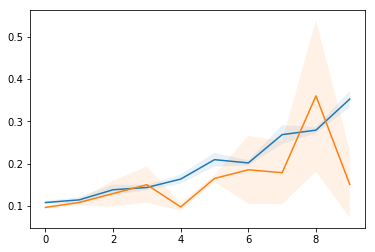

In [76]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')